In [1]:
import bookutils.setup
from typing import Tuple, List, Callable, Set, Any
from urllib.parse import urlparse
from Fuzzer import fuzzer
import random
import matplotlib.pyplot as plt

In [2]:
url = "http://www.google.com/search?q=fuzzing"
urlparse(url)

ParseResult(scheme='http', netloc='www.google.com', path='/search', params='', query='q=fuzzing', fragment='')

In [3]:
def http_program(url: str) -> bool:
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + 
                         repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True

In [4]:
http_program(url)

True

In [5]:
fuzzer(char_start=32, char_range=96) # 96 printable ASCII characters exist

'"N&+slk%h\x7fyp5o\'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5w}pMmPodJM,_'

---

Let's try fuzzing 1000 times. How many valid URLs to expect?

In [6]:
for i in range(1000):
    try:
        url = fuzzer()
        result = http_program(url)
        print("Success!")
    except ValueError:
        pass

---

Let's build the function that mutates a given seed

In [7]:
def mutate(s: str) -> str:
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    mutator = random.choice(mutators)
    return mutator(s)

Let's build our mutators

A. Delete

In [8]:
def delete_random_character(s: str) -> str:
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    return s[:pos] + s[pos + 1:]

In [9]:
# Example
seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(repr(x))

'A qick brown fox'
'A quck brown fox'
'A quick bown fox'
'A quik brown fox'
' quick brown fox'
'A quickbrown fox'
' quick brown fox'
'A qick brown fox'
'A quick brown fx'
'A qick brown fox'


B. Insert

In [10]:
def insert_random_character(s: str) -> str:
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    return s[:pos] + random_character + s[pos:]

In [11]:
for i in range(10):
    print(repr(insert_random_character(seed_input)))

'A qutick brown fox'
'A quick brown foFx'
'A quic?k brown fox'
'A quick brown fHox'
'A quick =brown fox'
'A quick broAwn fox'
'A quickA brown fox'
'A quick brown jfox'
'A quiLck brown fox'
'A quick brown foxB'


C. Flip

In [12]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    return s[:pos] + new_c + s[pos + 1:]

In [13]:
for i in range(10):
    print(repr(flip_random_character(seed_input)))

'A quick brkwn fox'
'A quick brown f/x'
'A quick broWn fox'
'A q}ick brown fox'
'A quyck brown fox'
'A quibk brown fox'
'A quick `rown fox'
'A qqick brown fox'
'A quick brown f/x'
'A quick brown f\x7fx'


Combine all the above

In [14]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

'A quick broWn fox'
'A quick brow~ fox'
'A quick brownfox'
'A qu)ck brown fox'
'A quick brown ox'
'A quick brown foxr'
'A quick brown .fox'
'A quick brown fo'
'A quick brown ox'
'A quick brownfox'


---

What percentage of mutants are valid?

In [15]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutate(seed_input)
    try:
        result = http_program(inp)
        valid_inputs.add(inp)
    except:
        pass

perc = len(valid_inputs) / trials
print("%0.2f%% of inputs are valid" % perc)

0.85% of inputs are valid


---

### Multiple Mutations

In [16]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutations = 50
inp = seed_input
for i in range(mutations):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'RhttCpa:/#/www.google.co/search?q=fuzzing'
10 mutations: 'RhttCa:/#/www.go1ogle*co/s%arch?q9fuzzing'
15 mutations: 'RhtCa:/#/ww.go1gle*co/sn%arch?q9fuzzinw'
20 mutations: 'RhtC[a:/#/w.go1ge*co/sn%a2c?q9fuzzinw'
25 mutations: 'RhtC[a:/#/w.go1Qe*co/sn%a2c?q9foujznw'
30 mutations: 'RhC[a:/#/rw.go1Qe|*so/sn%ac?q9foujznw'
35 mutations: 'RhYC[ai:/#-rw.go1Qe|*so/szn%ac?q9fowjznw'
40 mutations: 'RhYC[ai:/#-vrw.ggo1Qe|*so]/srn%ac?q9fowznw'
45 mutations: 'RhYC\x1bai:-vrw.gfo1Qe|*so]/ssn%ac?q9fowznw'


What percentage of mutants are valid?

In [17]:
def mutate(s: str, n_mutations: int = 1) -> str:
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]

    for i in range(n_mutations):
        mutator = random.choice(mutators)
        s = mutator(s)
    return s

In [18]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutate(seed_input, n_mutations=10)
    try:
        result = http_program(inp)
        valid_inputs.add(inp)
    except:
        pass

perc = len(valid_inputs) / trials
print("%0.2f%% of inputs are valid" % perc)

0.10% of inputs are valid


- The input gets hardly recongnizable quickly
- Risk of having invalid input
- Key to success: **guide these mutations using coverage**!

# Greybox Fuzzing

First, some refactoring

In [19]:
from Fuzzer import Fuzzer, Runner
from Coverage import Coverage, population_coverage, Location

In [20]:
# Class that runs a function with a given input
class FunctionRunner(Runner):
    def __init__(self, function: Callable) -> None:
        """Initialize.  `function` is a function to be executed"""
        self.function = function

    def run_function(self, inp: str) -> Any:
        return self.function(inp)

    def run(self, inp: str) -> Tuple[Any, str]:
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL

        return result, outcome

In [21]:
http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

In [22]:
# Extends the above to store the coverage as well
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self, inp: str) -> Any:
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc

        self._coverage = cov.coverage()
        return result

    def coverage(self) -> Set[Location]:
        return self._coverage

In [23]:
class MutationFuzzer(Fuzzer):
    """Base class for mutational fuzzing"""

    def __init__(self, seed: List[str],
                 min_mutations: int = 2,
                 max_mutations: int = 10) -> None:
        """Constructor.
        `seed` - a list of (input) strings to mutate.
        `min_mutations` - the minimum number of mutations to apply.
        `max_mutations` - the maximum number of mutations to apply.
        """
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self) -> None:
        self.population = self.seed
        self.seed_index = 0

    def mutate(self, inp: str) -> str:
        return mutate(inp)

    def create_candidate(self) -> str:
        """Create a new candidate by mutating a population member"""
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for i in range(trials):
            candidate = self.mutate(candidate)
        return candidate

    def fuzz(self) -> str:
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp

### For Greybox Fuzzing, we need to refactor our code in two classes.
### The implementation is omitted from the live coding session but is provided in the materials

In [24]:
http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")
# equivalent to "http_program("https://foo.bar/")

(True, 'PASS')

In [25]:
print(list(http_runner.coverage())[:5])

[('http_program', 7), ('urlparse', 395), ('http_program', 4), ('urlparse', 401), ('_coerce_args', 126)]


In [26]:
class MutationCoverageFuzzer(MutationFuzzer):
    """Fuzz with mutated inputs based on coverage"""

    def reset(self) -> None:
        super().reset()
        self.coverages_seen: Set[frozenset] = set()
        # Now empty; we fill this with seed in the first fuzz runs
        self.population = []

    def run(self, runner: FunctionCoverageRunner) -> Any:
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner) # just runs the function
        new_coverage = frozenset(runner.coverage()) # the new coverage
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen: # the core of greybox fuzzing
            # We have new coverage
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)

        return result

In [27]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000) # runs() --> call run() 10000 times
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://www*googlacomsear#h?q=fuzz\\)ng',
 'http://\x7fww&oOgle.com/seirchq=fuZzmng',
 'http://\x7fww&oOele.co+seirfchq9fuZzmng',
 'http://w\x7fw.googl.com/searcNyhq=fuzzing;',
 'http://www*googla?cmsar#h?q=fuzz\\)ng',
 'http://www*g/oglacms;ear#h?=fuzz\\)nyg',
 'http://ww*g/ooqcms;eaBrh?=fuzz\\)nyg',
 'http://ww*g/ooq;cms;eaBr/=&uzz\\)nyg',
 'http://ww*/ooqcs;e/aBrh?=fuzz\\)nyg',
 'http://ww*/ooqcs;a/#aBrh?=fuzz~\\)yf',
 'http://ww+/ooqcs;a?#aBkrh3?=fUzz~\x1cy',
 'http://ww*/oo/ks;e/i@(r?=fuzz\\#nxg']

Success! In our population, each and every input now is valid and has a different coverage, coming from various combinations of schemes, paths, queries, and fragments.

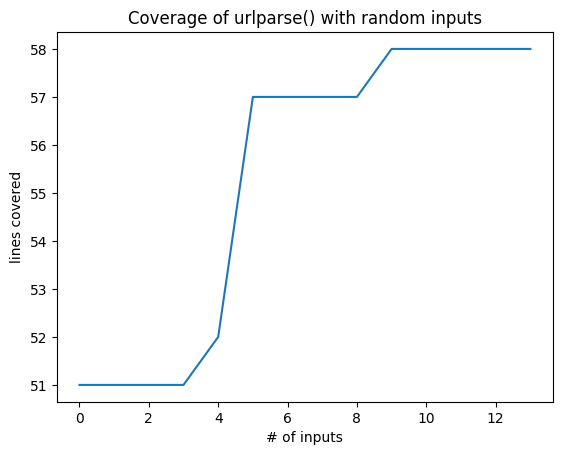

In [122]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, http_program)
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');